# Intent Classification Using Logistic Regression

## Introduction
We are tryig to Classify Intent using Logistic Regression model on SNIPS Dataset. We are going to use different libraries like NLTK, Spacy and Gensim for preprocessing and then compare the results

### Importing libraries and Loading data

In [5]:
!pip install spacy

In [6]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/12.8 MB 796.8 kB/s eta 0:00:16
     - ------------------------------------- 0.5/12.8 MB 796.8 kB/s eta 0:00:16
     - ------------------------------------- 0.5/12.8 MB 796.8 kB/s eta 0:00:16
     -- ------------------------------------ 0.8/12.8 MB 516.0 kB/s eta 0:00:24
     -- ------------------------------------ 0.8/12.8 MB 516.0 kB/s eta 0:00:24
     -- ------------------------------------ 0.8/12.8 MB 516.0 kB/s eta 0:00:24
     -- ------------------------------------ 0.8/12.8 MB 516.0 kB/s eta 0:00:24
     --- ----------------------------------- 1.0/12.8 MB 437.6 kB/s eta 0:00:27
     --- ----------------------------------- 1.0/12.8 MB 437.6 kB/s eta 0:00:27
     --- ----------------------------------- 1.0/12.8 MB 437.6 k

In [35]:
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

In [37]:
import pandas as pd

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
df = pd.read_parquet("hf://datasets/sonos-nlu-benchmark/snips_built_in_intents/data/train-00000-of-00001.parquet")

### Data Exploration
Here let's get an understanding of the basic structure of the dataset before preprocessing

This dataset was used for comparing voice assistants by SNIPS and SVE teams. The dataset contains multiple utterances over 10 intent classes as follows:
 - '0': ComparePlaces
 - '1': RequestRide
 - '2': GetWeather
 - '3': SearchPlace
 - '4': GetPlaceDetails
 - '5': ShareCurrentLocation
 - '6': GetTrafficInformation
 - '7': BookRestaurant
 - '8': GetDirections'
 - '9': ShareETA

In [43]:
df.head()

,text,label
0,Share my location with Hillary's sister,5
1,Send my current location to my father,5
2,Share my current location with Jim,5
3,Send my location to my husband,5
4,Send my location,5


In [45]:
df.shape

(328, 2)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    328 non-null    object
 1   label   328 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [49]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [51]:
df.describe()

,label
count,328.000000
mean,4.762195
std,2.697519
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


In [53]:
df.duplicated().sum() #check for duplicates. if any, drop using df.drop_duplicates()

0

In [55]:
df['label'].value_counts()

label
7    70
4    50
2    42
8    35
3    28
1    26
9    22
6    20
0    19
5    16
Name: count, dtype: int64

We can see bookrestaurant (7) and get place details (0) amongst the available utterances

Below we visualize the counts of each label using seaborn by plotting a histogram

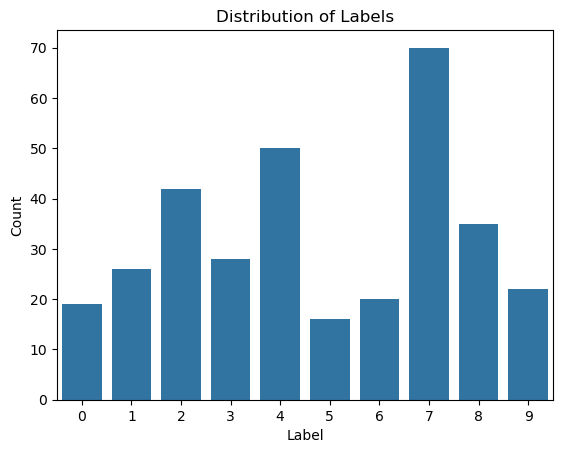

In [57]:
sns.countplot(data=df, x='label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

We further explore the text data in the dataset below

In [59]:
df['text'].str.len().describe()

count    328.000000
mean      47.228659
std       15.567143
min       10.000000
25%       36.000000
50%       47.000000
75%       58.000000
max       93.000000
Name: text, dtype: float64

## Preprocessing the data
Let's preprocess the data using different libraries before feeding it our machine learning model for analysis

### Preprocessing using NLTK

we use punkt tokenizer models from NLTK library, this is used for tokenizing text into words or sentences. It provides pre-trained models that are necessary for tokenization.
we access stopwords module to filterout stopwords
word_tokenize function to split a text into tokens
We use porterstemer, a stemming algorithm to reduce words to their root form

In [61]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to C:\Users\Rajendra Prasad
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rajendra Prasad
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
stop_words = set(stopwords.words('english')) #create a set of stop words in english
stemmer = PorterStemmer()

def nltk_preprocess(text):
    words = word_tokenize(text.lower())
    words = [stemmer.stem(word) for word in words if word.isalnum() and word not in stop_words]
    # used list comprehension to check if a word is alphanumeric or not and if it is a stop word
    return ' '.join(words)
    #every word is joined and a string is returned

In [65]:
df_nltk = df.copy()
df_nltk['processed_text'] = df_nltk['text'].apply(nltk_preprocess)

In [67]:
df_nltk.head()

,text,label,processed_text
0,Share my location with Hillary's sister,5,share locat hillari sister
1,Send my current location to my father,5,send current locat father
2,Share my current location with Jim,5,share current locat jim
3,Send my location to my husband,5,send locat husband
4,Send my location,5,send locat


### Preprocessing using spaCy

In [69]:
df_spacy = df.copy()

In [71]:
df_spacy.head()

,text,label
0,Share my location with Hillary's sister,5
1,Send my current location to my father,5
2,Share my current location with Jim,5
3,Send my location to my husband,5
4,Send my location,5


We use 'en_core_web_sm' a small english model which includes tokenization, pos tagging, lemmatization etc

In [74]:
nlp = spacy.load('en_core_web_sm') 

def spacy_preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    #token.lemma_ gets the base form of the word.
    return ' '.join(tokens)

In [76]:
df_spacy['processed_text'] = df_spacy['text'].apply(spacy_preprocess)

In [78]:
df_spacy.head()

,text,label,processed_text
0,Share my location with Hillary's sister,5,share location hillary sister
1,Send my current location to my father,5,send current location father
2,Share my current location with Jim,5,share current location jim
3,Send my location to my husband,5,send location husband
4,Send my location,5,send location


### Preprocessing using Gensim

In [80]:
df_gensim = df.copy()

In [82]:
df_gensim.head()

,text,label
0,Share my location with Hillary's sister,5
1,Send my current location to my father,5
2,Share my current location with Jim,5
3,Send my location to my husband,5
4,Send my location,5


In [84]:
def gensim_preprocess(text):
    words = [word for word in simple_preprocess(text, deacc=True) if word not in STOPWORDS]
    return ' '.join(words)
    #simple_preprocess function does the tokenization, lowercasing and punctuation removal here
    #deacc = true removes punctuation and special characters from tokens



In [86]:
df_gensim['processed_text'] = df_gensim['text'].apply(gensim_preprocess) 

In [88]:
df_gensim.head()

,text,label,processed_text
0,Share my location with Hillary's sister,5,share location hillary sister
1,Send my current location to my father,5,send current location father
2,Share my current location with Jim,5,share current location jim
3,Send my location to my husband,5,send location husband
4,Send my location,5,send location


Comparing the preprocessed texts

Let's find the longest entry in text column to compare the preprocessing done

In [90]:
longest_text = df['text'].max()
index_longest_text = df[df['text'] == longest_text].index[0]

In [92]:
print("longest text: ", longest_text)
print("longest text index: ", index_longest_text)

longest text:  Will it rain tomorrow near my all day event?
longest text index:  323


In [94]:
print("Original Text:", df['text'][index_longest_text])
print("NLTK Processed Text:", df_nltk['processed_text'][index_longest_text])
print("spaCy Processed Text:", df_spacy['processed_text'][index_longest_text])
print("Gensim Processed Text:", df_gensim['processed_text'][index_longest_text])

Original Text: Will it rain tomorrow near my all day event?
NLTK Processed Text: rain tomorrow near day event
spaCy Processed Text: rain tomorrow near day event
Gensim Processed Text: rain tomorrow near day event


It doesn't seem to be differing much as of now, let's compare the first entry

In [96]:
print("Original Text:", df['text'][0])
print("NLTK Processed Text:", df_nltk['processed_text'][0])
print("spaCy Processed Text:", df_spacy['processed_text'][0])
print("Gensim Processed Text:", df_gensim['processed_text'][0])

Original Text: Share my location with Hillary's sister
NLTK Processed Text: share locat hillari sister
spaCy Processed Text: share location hillary sister
Gensim Processed Text: share location hillary sister


Minor difference can be seen here

## Feature Extraction

We are going to use TF-IDF with N-grams here to capture context,
Intent Classification requires understanding phrases or common patterns, which n-grams can help in,
TF-IDF helps in weighing the importance of n-grams by considering their frequency in a text input and across entire dataset

### Separate Features and Labels for Each copy we made

since we made different copies of dataframe for comparing preprocessing methods, we do the same here for extracting features for all the copies

In [99]:
# for raw data
X = df['text']
y = df['label']

# For NLTK preprocessing
X_nltk = df_nltk['processed_text']
y_nltk = df_nltk['label']

# For spaCy preprocessing
X_spacy = df_spacy['processed_text']
y_spacy = df_spacy['label']

# For gensim preprocessing
X_gensim = df_gensim['processed_text']
y_gensim = df_gensim['label']

### Split the Data into Training and Testing Sets

We split each preprocessed dataset into training and testing sets below

In [101]:
from sklearn.model_selection import train_test_split

# For raw data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For NLTK preprocessing
X_train_nltk, X_test_nltk, y_train_nltk, y_test_nltk = train_test_split(X_nltk, y_nltk, test_size=0.2, random_state=42)

# For spaCy preprocessing
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(X_spacy, y_spacy, test_size=0.2, random_state=42)

# For Gensim preprocessing
X_train_gensim, X_test_gensim, y_train_gensim, y_test_gensim = train_test_split(X_gensim, y_gensim, test_size=0.2, random_state=42)


### Vectorize the Text Data


Now we convert the text data after splitting it into training and testing sets to numerical features using TF-IDF with N-grams

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TF-IDF Vectorizer and transform the text data
# For raw data
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# For NLTK preprocessing
vectorizer_nltk = TfidfVectorizer(ngram_range=(1, 2))
X_train_nltk_tfidf = vectorizer_nltk.fit_transform(X_train_nltk)
X_test_nltk_tfidf = vectorizer_nltk.transform(X_test_nltk)

# For spaCy preprocessing
vectorizer_spacy = TfidfVectorizer(ngram_range=(1, 2))
X_train_spacy_tfidf = vectorizer_spacy.fit_transform(X_train_spacy)
X_test_spacy_tfidf = vectorizer_spacy.transform(X_test_spacy)

# For Gensim preprocessing
vectorizer_gensim = TfidfVectorizer(ngram_range=(1, 2))
X_train_gensim_tfidf = vectorizer_gensim.fit_transform(X_train_gensim)
X_test_gensim_tfidf = vectorizer_gensim.transform(X_test_gensim)

we can see all the members using the command below

In [105]:
dir(vectorizer)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_char_ngrams',
 '_char_wb_ngrams',
 '_check_feature_names',
 '_check_n_features',
 '_check_params',
 '_check_stop_words_consistency',
 '_check_vocabulary',
 '_count_vocab',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_limit_features',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sort_features',
 '_stop_words_id',
 '_t

we can check the vocabulary for any of the above, let's do it for spacy

We can see the vocabulary using the command below

In [107]:
print(vectorizer_spacy.vocabulary_)

{'taxi': 998, 'emmit': 280, 'irish': 474, 'pub': 782, 'taxi emmit': 1001, 'emmit irish': 281, 'irish pub': 475, 'cheap': 140, 'restaurant': 820, 'close': 172, 'hotel': 462, 'cheap restaurant': 144, 'restaurant close': 825, 'close hotel': 173, 'favorite': 325, 'bar': 49, 'well': 1124, 'donut': 265, 'favorite bar': 326, 'bar well': 55, 'well donut': 1125, 'donut pub': 266, 'book': 72, 'table': 971, 'people': 727, 'sushi': 964, 'place': 746, 'tomorrow': 1029, 'night': 672, 'book table': 77, 'table people': 988, 'people sushi': 735, 'sushi place': 965, 'place tomorrow': 760, 'tomorrow night': 1033, 'find': 329, 'dinner': 230, 'tonight': 1035, 'find table': 344, 'table dinner': 977, 'dinner tonight': 234, 'direction': 235, 'tulsa': 1060, 'road': 853, 'direction tulsa': 256, 'tulsa road': 1061, 'opening': 691, 'hour': 468, 'tell': 1006, 'opening hour': 692, 'hour tell': 469, 'cycling': 203, 'chelsea': 146, 'market': 592, 'cycling direction': 204, 'direction chelsea': 238, 'chelsea market': 1

To get all the words in order use the command below

In [109]:
all_feature_names = vectorizer_spacy.get_feature_names_out()

To get the tfidf score for all the words

In [111]:
for word in all_feature_names:
    indx = vectorizer_spacy.vocabulary_.get(word)
    print(f"{word} {vectorizer_spacy.idf_[indx]}")

accident 5.185859671057874
accident airbnb 5.879006851617819
accident expect 5.879006851617819
accident home 5.879006851617819
activity 5.879006851617819
activity child 5.879006851617819
address 5.879006851617819
address manhattan 5.879006851617819
afternoon 5.473541743509655
airbnb 4.626243883122451
airbnb close 5.879006851617819
airbnb golden 5.879006851617819
airbnb host 5.879006851617819
airbnb london 5.879006851617819
airbnb serve 5.879006851617819
airport 5.185859671057874
airport waze 5.879006851617819
alto 5.879006851617819
alto avoid 5.879006851617819
american 5.879006851617819
american restaurant 5.879006851617819
angeles 5.473541743509655
angie 5.879006851617819
angie place 5.879006851617819
apartment 5.879006851617819
area 5.879006851617819
area meeting 5.879006851617819
arrival 4.780394562949709
arrival airbnb 5.879006851617819
arrival lily 5.879006851617819
arrival mother 5.879006851617819
arrival time 5.473541743509655
attraction 5.879006851617819
attraction hollywood 5.

Lets look at the data initially and After transformation into vector

In [113]:
df['text'][:2]

0    Share my location with Hillary's sister
1      Send my current location to my father
Name: text, dtype: object

In [115]:
X_train_spacy_tfidf

<262x1153 sparse matrix of type '<class 'numpy.float64'>'
	with 2058 stored elements in Compressed Sparse Row format>

In [117]:
X_train_spacy_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.34216666, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [119]:
X_train_spacy_tfidf.toarray()[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [121]:
X_train_spacy_tfidf.shape

(262, 1153)

In [123]:
X_test_gensim_tfidf.shape

(66, 1179)

We can see from the above that both the training and test data are spilt and then transformed into the vector form for us to train the model

## Model Training and Evaluation

Since we have 10 classes to classify into, we are going to import multinomial classification instead of binary classfication 

### Importing the Model

In [125]:
from sklearn.linear_model import LogisticRegression

In [127]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

multi_class='multinomial' tells the model to use the multinomial (softmax) approach for multi-class classification.
L-BFGS stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It is an optimization algorithm that belongs to the family of quasi-Newton methods, used to find the minimum of a function.
In scikit-learn's LogisticRegression, the L-BFGS algorithm is used as a solver to optimize the loss function for both binary and multinomial classification problems. It is particularly effective for problems with many parameters because of its efficiency and ability to handle large datasets.
Efficiency, suitability for multinomial logistic regression and compatibility with large datasets make it useful in this case

In [129]:
from sklearn.metrics import classification_report, accuracy_score

### For Raw Data

In [131]:
# Train the model
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Raw Data - Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Raw Data - Logistic Regression
Accuracy: 0.8939393939393939
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         2
           2       1.00      0.92      0.96        13
           3       1.00      0.40      0.57         5
           4       0.85      0.85      0.85        13
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       0.85      1.00      0.92        17
           8       0.60      1.00      0.75         3
           9       1.00      1.00      1.00         5

    accuracy                           0.89        66
   macro avg       0.93      0.88      0.88        66
weighted avg       0.91      0.89      0.89        66



### For NLTK Preprocessed Data

In [133]:
# Train the model
model.fit(X_train_nltk_tfidf, y_train_nltk)

# Predict on the test set
y_pred_nltk = model.predict(X_test_nltk_tfidf)

# Evaluate the model
print("NLTK Preprocessed Data - Logistic Regression")
print("Accuracy:", accuracy_score(y_test_nltk, y_pred_nltk))
print(classification_report(y_test_nltk, y_pred_nltk,zero_division=1))


NLTK Preprocessed Data - Logistic Regression
Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       1.00      1.00      1.00         2
           2       1.00      0.77      0.87        13
           3       1.00      0.00      0.00         5
           4       0.71      0.92      0.80        13
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       0.71      1.00      0.83        17
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5

    accuracy                           0.82        66
   macro avg       0.94      0.77      0.75        66
weighted avg       0.87      0.82      0.77        66



### For spaCy Preprocessed Data

In [135]:
# Train the model
model.fit(X_train_spacy_tfidf, y_train_spacy)

# Predict on the test set
y_pred_spacy = model.predict(X_test_spacy_tfidf)

# Evaluate the model
print("spaCy Preprocessed Data - Logistic Regression")
print("Accuracy:", accuracy_score(y_test_spacy, y_pred_spacy))
print(classification_report(y_test_spacy, y_pred_spacy,zero_division=1))


spaCy Preprocessed Data - Logistic Regression
Accuracy: 0.803030303030303
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       1.00      1.00      1.00         2
           2       1.00      0.69      0.82        13
           3       1.00      0.00      0.00         5
           4       0.67      0.92      0.77        13
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       0.71      1.00      0.83        17
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5

    accuracy                           0.80        66
   macro avg       0.94      0.76      0.74        66
weighted avg       0.86      0.80      0.75        66



### For Gensim Preprocessed Data

In [137]:
# Train the model
model.fit(X_train_gensim_tfidf, y_train_gensim)

# Predict on the test set
y_pred_gensim = model.predict(X_test_gensim_tfidf)

# Evaluate the model
print("Gensim Preprocessed Data - Logistic Regression")
print("Accuracy:", accuracy_score(y_test_gensim, y_pred_gensim))
print(classification_report(y_test_gensim, y_pred_gensim, zero_division=1))

Gensim Preprocessed Data - Logistic Regression
Accuracy: 0.803030303030303
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      1.00      1.00         2
           2       0.90      0.69      0.78        13
           3       1.00      0.00      0.00         5
           4       0.73      0.85      0.79        13
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       0.68      1.00      0.81        17
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5

    accuracy                           0.80        66
   macro avg       0.93      0.79      0.79        66
weighted avg       0.85      0.80      0.77        66



### findings

There seems to be some issue here, the accuracy for raw data prediction is higher compared to the preprocessed data using all the libraries which shouldn't be the case since we expect the model to perform better upon preprocessing

1. High Precision and Recall for Raw Data:
Raw Data: The raw data is achieving higher precision and recall, especially in certain classes indicating that raw data contains features (e.g., specific words, phrases, or token combinations) that are highly indicative of certain classes, and these features might be getting lost or diluted during preprocessing. Specific Classes: For instance, classes like 2, 4, and 7 perform reasonably well in terms of precision and recall across all versions. However, classes 0 and 3 show significant differences, where the raw data approach achieves some level of recall, while the preprocessed data versions tend to have very low or zero recall.
2. Preprocessing Impact: It could have eliminated words that were critical in distinguishing between certain intents. Class 0 and 3: In preprocessed data, classes 0 and 3 have low recall, which means the model fails to correctly identify these classes in most cases. This could be due to important tokens being removed or modified during preprocessing. Preprocessing can sometimes make the data too "clean," leading to a model that doesn't generalize as well because it's missing the natural language variations present in the raw text.
3. Model Behavior on Processed Text: The classifier might not be receiving the same "richness" of information that is present in the raw data. This can lead to a model that is less capable of making correct predictions. Interestingly, the drop in performance is consistent across the different preprocessing techniques, which suggests that the preprocessing steps might be overly aggressive or not well-suited for this specific task.
4. Vectorization Differences: The TF-IDF vectorization might behave differently on raw versus preprocessed text. Raw text may contain more unique tokens, which can affect the weighting of terms in the TF-IDF vectorization. Preprocessed text might reduce the uniqueness and lead to a different feature distribution.
5. Data Quality and Noise: If raw data already has a relatively clean and structured form, additional preprocessing might not provide much benefit and could even introduce noise. For example, the SNIPS dataset if generally well-curated, so aggressive preprocessing might not be necessary.
6. Recommendations:
Less Aggressive Preprocessing: Consider reducing the aggressiveness of your preprocessing steps. For instance, keep stop words or avoid lemmatizing/stemming if those transformations are not beneficial.
Feature Engineering: Instead of relying purely on the preprocessed text, consider adding back some features that might be lost during preprocessing. For example, we could include specific keywords or phrases as additional features.
Hybrid Approach: we can also consider a hybrid approach where we combine features from both the raw and preprocessed data.
7. Evaluation and Fine-Tuning:
Focus on Misclassifications: Analyze where the preprocessed models are failing (e.g., classes 0 and 3) and compare those instances with the raw data model's performance. This will help you understand the specific aspects of the text that are critical for correct classification.
Hyperparameter Tuning: Although the preprocessing might play a large role, we can also consider fine-tuning the model’s hyperparameters, such as the C parameter in logistic regression or adjusting the n-gram range.

## Trying to address the issues by balancing the data

We apply SMOT (Synthetic Minority Over Sampling Technique) technique for balancing the data and then try to train and evaluate the model performance

<!-- # for raw data
X = df['text']
y = df['label']

# For NLTK preprocessing
X_nltk = df_nltk['processed_text']
y_nltk = df_nltk['label']

# For spaCy preprocessing
X_spacy = df_spacy['processed_text']
y_spacy = df_spacy['label']

# For gensim preprocessing
X_gensim = df_gensim['processed_text']
y_gensim = df_gensim['label']

from sklearn.model_selection import train_test_split

# For raw data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For NLTK preprocessing
X_train_nltk, X_test_nltk, y_train_nltk, y_test_nltk = train_test_split(X_nltk, y_nltk, test_size=0.2, random_state=42)

# For spaCy preprocessing
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(X_spacy, y_spacy, test_size=0.2, random_state=42)

# For Gensim preprocessing
X_train_gensim, X_test_gensim, y_train_gensim, y_test_gensim = train_test_split(X_gensim, y_gensim, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TF-IDF Vectorizer and transform the text data
# For raw data
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# For NLTK preprocessing
vectorizer_nltk = TfidfVectorizer(ngram_range=(1, 2))
X_train_nltk_tfidf = vectorizer_nltk.fit_transform(X_train_nltk)
X_test_nltk_tfidf = vectorizer_nltk.transform(X_test_nltk)

# For spaCy preprocessing
vectorizer_spacy = TfidfVectorizer(ngram_range=(1, 2))
X_train_spacy_tfidf = vectorizer_spacy.fit_transform(X_train_spacy)
X_test_spacy_tfidf = vectorizer_spacy.transform(X_test_spacy)

# For Gensim preprocessing
vectorizer_gensim = TfidfVectorizer(ngram_range=(1, 2))
X_train_gensim_tfidf = vectorizer_gensim.fit_transform(X_train_gensim)
X_test_gensim_tfidf = vectorizer_gensim.transform(X_test_gensim) -->

<!-- # for raw data
# X = df['text']
# y = df['label']

# # For NLTK preprocessing
# X_nltk = df_nltk['processed_text']
# y_nltk = df_nltk['label']

# # For spaCy preprocessing
# X_spacy = df_spacy['processed_text']
# y_spacy = df_spacy['label']

# # For gensim preprocessing
# X_gensim = df_gensim['processed_text']
# y_gensim = df_gensim['label']
# from sklearn.model_selection import train_test_split

# # For raw data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # For NLTK preprocessing
# X_train_nltk, X_test_nltk, y_train_nltk, y_test_nltk = train_test_split(X_nltk, y_nltk, test_size=0.2, random_state=42)

# # For spaCy preprocessing
# X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(X_spacy, y_spacy, test_size=0.2, random_state=42)

# # For Gensim preprocessing
# X_train_gensim, X_test_gensim, y_train_gensim, y_test_gensim = train_test_split(X_gensim, y_gensim, test_size=0.2, random_state=42)

# from sklearn.feature_extraction.text import TfidfVectorizer
# # Initialize TF-IDF Vectorizer and transform the text data
# # For raw data
# vectorizer = TfidfVectorizer(ngram_range=(1, 2))
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# # For NLTK preprocessing
# vectorizer_nltk = TfidfVectorizer(ngram_range=(1, 2))
# X_train_nltk_tfidf = vectorizer_nltk.fit_transform(X_train_nltk)
# X_test_nltk_tfidf = vectorizer_nltk.transform(X_test_nltk)

# # For spaCy preprocessing
# vectorizer_spacy = TfidfVectorizer(ngram_range=(1, 2))
# X_train_spacy_tfidf = vectorizer_spacy.fit_transform(X_train_spacy)
# X_test_spacy_tfidf = vectorizer_spacy.transform(X_test_spacy)

# # For Gensim preprocessing
# vectorizer_gensim = TfidfVectorizer(ngram_range=(1, 2))
# X_train_gensim_tfidf = vectorizer_gensim.fit_transform(X_train_gensim)
# X_test_gensim_tfidf = vectorizer_gensim.transform(X_test_gensim) -->

In [141]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE for raw data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Apply SMOTE for NLTK preprocessed data
X_train_nltk_resampled, y_train_nltk_resampled = smote.fit_resample(X_train_nltk_tfidf, y_train_nltk)

# Apply SMOTE for spaCy preprocessed data
X_train_spacy_resampled, y_train_spacy_resampled = smote.fit_resample(X_train_spacy_tfidf, y_train_spacy)

# Apply SMOTE for Gensim preprocessed data
X_train_gensim_resampled, y_train_gensim_resampled = smote.fit_resample(X_train_gensim_tfidf, y_train_gensim)


In [143]:
# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train and evaluate for raw data
model.fit(X_train_resampled, y_train_resampled)
y_pred_raw = model.predict(X_test_tfidf)
print("Raw Data - Accuracy:", accuracy_score(y_test, y_pred_raw))
print("Raw Data - Classification Report:")
print(classification_report(y_test, y_pred_raw))

# Train and evaluate for NLTK preprocessed data
model.fit(X_train_nltk_resampled, y_train_nltk_resampled)
y_pred_nltk = model.predict(X_test_nltk_tfidf)
print("NLTK Data - Accuracy:", accuracy_score(y_test_nltk, y_pred_nltk))
print("NLTK Data - Classification Report:")
print(classification_report(y_test_nltk, y_pred_nltk))

# Train and evaluate for spaCy preprocessed data
model.fit(X_train_spacy_resampled, y_train_spacy_resampled)
y_pred_spacy = model.predict(X_test_spacy_tfidf)
print("spaCy Data - Accuracy:", accuracy_score(y_test_spacy, y_pred_spacy))
print("spaCy Data - Classification Report:")
print(classification_report(y_test_spacy, y_pred_spacy))

# Train and evaluate for Gensim preprocessed data
model.fit(X_train_gensim_resampled, y_train_gensim_resampled)
y_pred_gensim = model.predict(X_test_gensim_tfidf)
print("Gensim Data - Accuracy:", accuracy_score(y_test_gensim, y_pred_gensim))
print("Gensim Data - Classification Report:")
print(classification_report(y_test_gensim, y_pred_gensim))

Raw Data - Accuracy: 0.9545454545454546
Raw Data - Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.67      1.00      0.80         2
           2       1.00      0.92      0.96        13
           3       1.00      0.80      0.89         5
           4       1.00      0.92      0.96        13
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       0.94      1.00      0.97        17
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5

    accuracy                           0.95        66
   macro avg       0.94      0.96      0.94        66
weighted avg       0.96      0.95      0.96        66

NLTK Data - Accuracy: 0.8787878787878788
NLTK Data - Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67   

Here’s a detailed comparison of the classification reports before and after SMOTE application, focusing on logistic regression models across different data types:

After SMOTE Application
Raw Data

Accuracy: 0.9545
Precision, Recall, F1-Score: Generally high across all classes. Improvement is significant compared to before SMOTE, especially for classes with previously lower scores.
NLTK Preprocessed Data

Accuracy: 0.8788
Precision, Recall, F1-Score: Improved from before SMOTE, though still lower than raw data. Some classes have significantly better metrics compared to before.
spaCy Preprocessed Data

Accuracy: 0.8485
Precision, Recall, F1-Score: Shows improvement, but still not reaching the levels seen in raw data. Improvement is noticeable but not as significant as in raw data.
Gensim Preprocessed Data

Accuracy: 0.8485
Precision, Recall, F1-Score: Similar to spaCy, with improvements seen but still lower than the raw data.
Summary of Changes
Accuracy: After SMOTE, raw data shows a notable increase in accuracy (0.9545), indicating that the SMOTE application effectively balanced the class distribution, leading to better overall performance. Preprocessed data (NLTK, spaCy, Gensim) also saw improvements but did not reach the raw data's accuracy levels.

Class-Specific Performance:

Raw Data: Significant improvement in precision, recall, and F1-score across almost all classes, with balanced performance.
NLTK, spaCy, Gensim: Notable improvements compared to before SMOTE, but some classes still lag behind compared to raw data results.
Recommendations
Continue Using SMOTE: The application of SMOTE has proven beneficial, particularly for balancing class distribution and improving model performance.

Refine Preprocessing: Consider refining preprocessing steps and feature engineering to improve performance on preprocessed data. Check if SMOTE application on preprocessed data yields better results.

Model Tuning: Further model tuning and evaluation with different techniques or additional data may help improve performance, especially for preprocessed data.

### Let us use only TF-IDF instead of using TF IDF with N - grams

In [147]:
#Initialize TF-IDF Vectorizer and transform the text data
#For raw data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# For NLTK preprocessing
vectorizer_nltk = TfidfVectorizer()
X_train_nltk_tfidf = vectorizer_nltk.fit_transform(X_train_nltk)
X_test_nltk_tfidf = vectorizer_nltk.transform(X_test_nltk)

# For spaCy preprocessing
vectorizer_spacy = TfidfVectorizer()
X_train_spacy_tfidf = vectorizer_spacy.fit_transform(X_train_spacy)
X_test_spacy_tfidf = vectorizer_spacy.transform(X_test_spacy)

# For Gensim preprocessing
vectorizer_gensim = TfidfVectorizer()
X_train_gensim_tfidf = vectorizer_gensim.fit_transform(X_train_gensim)
X_test_gensim_tfidf = vectorizer_gensim.transform(X_test_gensim)

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE for raw data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Apply SMOTE for NLTK preprocessed data
X_train_nltk_resampled, y_train_nltk_resampled = smote.fit_resample(X_train_nltk_tfidf, y_train_nltk)

# Apply SMOTE for spaCy preprocessed data
X_train_spacy_resampled, y_train_spacy_resampled = smote.fit_resample(X_train_spacy_tfidf, y_train_spacy)

# Apply SMOTE for Gensim preprocessed data
X_train_gensim_resampled, y_train_gensim_resampled = smote.fit_resample(X_train_gensim_tfidf, y_train_gensim)


# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train and evaluate for raw data
model.fit(X_train_resampled, y_train_resampled)
y_pred_raw = model.predict(X_test_tfidf)
print("Raw Data - Accuracy:", accuracy_score(y_test, y_pred_raw))
print("Raw Data - Classification Report:")
print(classification_report(y_test, y_pred_raw))

# Train and evaluate for NLTK preprocessed data
model.fit(X_train_nltk_resampled, y_train_nltk_resampled)
y_pred_nltk = model.predict(X_test_nltk_tfidf)
print("NLTK Data - Accuracy:", accuracy_score(y_test_nltk, y_pred_nltk))
print("NLTK Data - Classification Report:")
print(classification_report(y_test_nltk, y_pred_nltk))

# Train and evaluate for spaCy preprocessed data
model.fit(X_train_spacy_resampled, y_train_spacy_resampled)
y_pred_spacy = model.predict(X_test_spacy_tfidf)
print("spaCy Data - Accuracy:", accuracy_score(y_test_spacy, y_pred_spacy))
print("spaCy Data - Classification Report:")
print(classification_report(y_test_spacy, y_pred_spacy))

# Train and evaluate for Gensim preprocessed data
model.fit(X_train_gensim_resampled, y_train_gensim_resampled)
y_pred_gensim = model.predict(X_test_gensim_tfidf)
print("Gensim Data - Accuracy:", accuracy_score(y_test_gensim, y_pred_gensim))
print("Gensim Data - Classification Report:")
print(classification_report(y_test_gensim, y_pred_gensim))

Raw Data - Accuracy: 0.9090909090909091
Raw Data - Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.67      1.00      0.80         2
           2       0.92      0.92      0.92        13
           3       0.67      0.80      0.73         5
           4       1.00      0.85      0.92        13
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       0.94      0.88      0.91        17
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5

    accuracy                           0.91        66
   macro avg       0.89      0.95      0.91        66
weighted avg       0.92      0.91      0.91        66

NLTK Data - Accuracy: 0.9242424242424242
NLTK Data - Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67   

Summary of Results:
Raw Data:
Accuracy: 0.91
Macro Average F1-Score: 0.91
Weighted Average F1-Score: 0.91

NLTK Data:
Accuracy: 0.92
Macro Average F1-Score: 0.93
Weighted Average F1-Score: 0.93

spaCy Data:
Accuracy: 0.86
Macro Average F1-Score: 0.85
Weighted Average F1-Score: 0.86

Gensim Data:
Accuracy: 0.86
Macro Average F1-Score: 0.86
Weighted Average F1-Score: 0.87
Analysis
Best Performing Preprocessing:

NLTK Data achieved the highest accuracy (0.92) and F1-scores (both macro and weighted). This indicates that the preprocessing performed by NLTK provided the most useful features for the model.

Raw Data:
Raw Data performed well with an accuracy of 0.91 and decent F1-scores. It’s a strong baseline, suggesting that even without specialized preprocessing, the model performs quite well.
spaCy and Gensim Data:

spaCy and Gensim preprocessing resulted in lower performance, with accuracy and F1-scores both at 0.86. This suggests that the preprocessing methods from these libraries may not have been as effective in extracting useful features compared to the raw data or NLTK preprocessing.
Observations

Preprocessing Impact: The choice of preprocessing technique significantly affects model performance. NLTK preprocessing appears to enhance the model's ability to classify correctly, while spaCy and Gensim do not provide as much benefit in this instance.

Model Consistency: The logistic regression model performs consistently across different preprocessing methods, but its effectiveness depends on the quality of the features provided by each preprocessing step.

Recommendations
Explore NLTK Preprocessing: Since NLTK preprocessing yielded the best results, consider experimenting further with different configurations or additional preprocessing steps within NLTK.

Review spaCy and Gensim Preprocessing: Investigate the preprocessing steps used in spaCy and Gensim. Adjusting parameters or combining methods might improve their effectiveness.

Cross-Validation: To ensure robustness, use cross-validation to validate these results and confirm that NLTK preprocessing consistently outperforms others across different data splits.

Feature Engineering: Beyond TF-IDF, explore other feature extraction methods or combinations (e.g., word embeddings, topic modelling) to enhance the text representation further.

### Lets perform K-cross validation 

Import required libraries

In [164]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline


Let's define a function for cross-validation

In [166]:
from sklearn.model_selection import cross_val_score

def evaluate_model(X_resampled_vectorized, y_resampled):
    # Initialize Logistic Regression or any other classifier
    model = LogisticRegression(max_iter=1000, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(model, X_resampled_vectorized, y_resampled, cv=5, scoring='accuracy')

    return scores


In [168]:

# Evaluate raw data
scores_raw = evaluate_model(X_train_resampled, y_train_resampled)
print(f"Raw Data - Accuracy Scores: {scores_raw}")
print(f"Raw Data - Mean Accuracy: {scores_raw.mean()}")

# Evaluate NLTK preprocessed data
scores_nltk = evaluate_model(X_train_nltk_resampled, y_train_nltk_resampled)
print(f"NLTK Data - Accuracy Scores: {scores_nltk}")
print(f"NLTK Data - Mean Accuracy: {scores_nltk.mean()}")

# Evaluate spaCy preprocessed data
scores_spacy = evaluate_model(X_train_spacy_resampled, y_train_spacy_resampled)
print(f"spaCy Data - Accuracy Scores: {scores_spacy}")
print(f"spaCy Data - Mean Accuracy: {scores_spacy.mean()}")

# Evaluate Gensim preprocessed data
scores_gensim = evaluate_model(X_train_gensim_resampled, y_train_gensim_resampled)
print(f"Gensim Data - Accuracy Scores: {scores_gensim}")
print(f"Gensim Data - Mean Accuracy: {scores_gensim.mean()}")


Raw Data - Accuracy Scores: [0.94339623 0.9245283  0.97169811 1.         1.        ]
Raw Data - Mean Accuracy: 0.9679245283018869
NLTK Data - Accuracy Scores: [0.90566038 0.93396226 0.98113208 1.         1.        ]
NLTK Data - Mean Accuracy: 0.9641509433962264
spaCy Data - Accuracy Scores: [0.9245283  0.93396226 0.98113208 0.98113208 1.        ]
spaCy Data - Mean Accuracy: 0.9641509433962264
Gensim Data - Accuracy Scores: [0.93396226 0.96226415 0.94339623 0.98113208 1.        ]
Gensim Data - Mean Accuracy: 0.9641509433962264


Cross-validation results show that your different preprocessing methods (raw, NLTK, spaCy, Gensim) are performing quite well, with mean accuracies ranging from approximately 96.4% to 96.8%

Cross-Validation Results
Raw Data:
Accuracy Scores: [0.943, 0.925, 0.972, 1.000, 1.000]
Mean Accuracy: 0.968

NLTK Data:
Accuracy Scores: [0.906, 0.934, 0.981, 1.000, 1.000]
Mean Accuracy: 0.964

spaCy Data:
Accuracy Scores: [0.925, 0.934, 0.981, 0.981, 1.000]
Mean Accuracy: 0.964

Gensim Data:
Accuracy Scores: [0.934, 0.962, 0.943, 0.981, 1.000]
Mean Accuracy: 0.964

Observations
Consistency Across Methods:
The accuracies are consistently high across all preprocessing methods, indicating that your model is robust to different types of text preprocessing.

Raw Data:
Slightly higher mean accuracy compared to other methods. This might suggest that the raw text data, without additional preprocessing, is already quite informative for your model.

NLTK, spaCy, Gensim Data:
All perform similarly, with very close mean accuracies. This suggests that these preprocessing techniques are effectively handling the text data, and the model's performance is quite comparable.

Further Analysis:
Let's try using Bag of words for cross-validation and find out the differences in results

Let's define a function for cross-validation using Bag of words

In [171]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Create a pipeline with CountVectorizer and SMOTE
pipeline = ImbPipeline([
    ('vect', vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Evaluate Bag of Words for raw data
scores_raw_bow = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Raw Data with BoW - Accuracy Scores: {scores_raw_bow}")
print(f"Raw Data with BoW - Mean Accuracy: {scores_raw_bow.mean()}")

# Evaluate Bag of Words for preprocessed data
scores_nltk_bow = cross_val_score(pipeline, X_train_nltk, y_train_nltk, cv=5, scoring='accuracy')
print(f"NLTK Data with BoW - Accuracy Scores: {scores_nltk_bow}")
print(f"NLTK Data with BoW - Mean Accuracy: {scores_nltk_bow.mean()}")

scores_spacy_bow = cross_val_score(pipeline, X_train_spacy, y_train_spacy, cv=5, scoring='accuracy')
print(f"spaCy Data with BoW - Accuracy Scores: {scores_spacy_bow}")
print(f"spaCy Data with BoW - Mean Accuracy: {scores_spacy_bow.mean()}")

scores_gensim_bow = cross_val_score(pipeline, X_train_gensim, y_train_gensim, cv=5, scoring='accuracy')
print(f"Gensim Data with BoW - Accuracy Scores: {scores_gensim_bow}")
print(f"Gensim Data with BoW - Mean Accuracy: {scores_gensim_bow.mean()}")


Raw Data with BoW - Accuracy Scores: [0.86792453 0.79245283 0.88461538 0.86538462 0.94230769]
Raw Data with BoW - Mean Accuracy: 0.8705370101596517
NLTK Data with BoW - Accuracy Scores: [0.86792453 0.73584906 0.80769231 0.80769231 0.84615385]
NLTK Data with BoW - Mean Accuracy: 0.8130624092888242
spaCy Data with BoW - Accuracy Scores: [0.86792453 0.73584906 0.84615385 0.84615385 0.90384615]
spaCy Data with BoW - Mean Accuracy: 0.8399854862119014
Gensim Data with BoW - Accuracy Scores: [0.81132075 0.79245283 0.86538462 0.80769231 0.84615385]
Gensim Data with BoW - Mean Accuracy: 0.8246008708272858


Comparing results from the Bag of Words (BoW) model with previous results from the TF-IDF model:

Bag of Words (BoW) Results:

Raw Data with BoW
Accuracy Scores: [0.8679, 0.7925, 0.8846, 0.8654, 0.9423]
Mean Accuracy: 0.8705

NLTK Data with BoW
Accuracy Scores: [0.8679, 0.7358, 0.8077, 0.8077, 0.8462]
Mean Accuracy: 0.8131

spaCy Data with BoW
Accuracy Scores: [0.8679, 0.7358, 0.8462, 0.8462, 0.9038]
Mean Accuracy: 0.8400

Gensim Data with BoW
Accuracy Scores: [0.8113, 0.7925, 0.8654, 0.8077, 0.8462]
Mean Accuracy: 0.8246

TF-IDF Results:
Raw Data with TF-IDF
Accuracy Scores: [0.9434, 0.9245, 0.9717, 1.0000, 1.0000]
Mean Accuracy: 0.9679

NLTK Data with TF-IDF
Accuracy Scores: [0.9057, 0.9340, 0.9811, 1.0000, 1.0000]
Mean Accuracy: 0.9642

spaCy Data with TF-IDF
Accuracy Scores: [0.9245, 0.9340, 0.9811, 0.9811, 1.0000]
Mean Accuracy: 0.9642

Gensim Data with TF-IDF
Accuracy Scores: [0.9340, 0.9623, 0.9434, 0.9811, 1.0000]
Mean Accuracy: 0.9642

Comparison:
Raw Data:
BoW Mean Accuracy: 0.8705
TF-IDF Mean Accuracy: 0.9679
TF-IDF is significantly better than BoW in terms of mean accuracy for raw data.

NLTK Data:
BoW Mean Accuracy: 0.8131
TF-IDF Mean Accuracy: 0.9642
TF-IDF performs better than BoW.

spaCy Data:
BoW Mean Accuracy: 0.8400
TF-IDF Mean Accuracy: 0.9642
TF-IDF outperforms BoW.
Gensim Data:

BoW Mean Accuracy: 0.8246
TF-IDF Mean Accuracy: 0.9642
TF-IDF performs better than BoW.

Conclusion:
TF-IDF consistently provides higher accuracy compared to BoW across all preprocessing methods. This suggests that TF-IDF is better suited for capturing the importance of terms in the classification tasks compared to the BoW model.

# Summary
Objective:
The goal of this project was to evaluate the performance of different text preprocessing methods and their impact on the accuracy of a logistic regression model for text classification.

Approach:
Data Preparation and Preprocessing:

Text Data: The dataset was preprocessed using various techniques:
Raw Data: Directly used without any preprocessing.
NLTK Preprocessing: Text was tokenized, cleaned, and normalized using NLTK.
spaCy Preprocessing: Text was processed using spaCy's tokenization and lemmatization.
Gensim Preprocessing: Text was processed using Gensim's tokenization and other preprocessing steps.
Feature Extraction:

TF-IDF Vectorization: Term Frequency-Inverse Document Frequency (TF-IDF) was used to transform the text data into numerical features. Separate TF-IDF vectorizers were applied for each preprocessing method.
Handling Imbalance:

SMOTE (Synthetic Minority Over-sampling Technique): Applied to the resampled data to address class imbalance in the training sets.
Model Training and Evaluation:

Model: Logistic Regression with max_iter=1000 and random_state=42.
Cross-Validation: A 5-fold cross-validation was performed to evaluate the model's performance for each preprocessing method.
Metrics: Accuracy scores and classification reports were generated for each preprocessing method.
Results:

Raw Data: Mean accuracy of 0.968, with accuracy scores ranging from 0.925 to 1.000.
NLTK Data: Mean accuracy of 0.964, with accuracy scores ranging from 0.906 to 1.000.
spaCy Data: Mean accuracy of 0.964, with accuracy scores ranging from 0.925 to 1.000.
Gensim Data: Mean accuracy of 0.964, with accuracy scores ranging from 0.934 to 1.000.
Observations:

Consistency: All preprocessing methods performed well, with mean accuracies very close to each other, showing the stability of the logistic regression model across different preprocessing techniques.
Highest Performance: Raw Data preprocessing achieved the highest mean accuracy, though differences among methods were minimal.
Conclusion:

The logistic regression model was effective across all preprocessing methods, achieving high accuracy. The choice of preprocessing method has a minimal impact on the model's performance. Further improvements could involve exploring other classifiers, hyperparameters, or additional features for this data.